# Gerekli Modüllerin/Kütüphanelerin Import Edilmesi

In [12]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset,DataLoader)
from skimage import io

import warnings
warnings.filterwarnings("ignore")
import time

# Verinin Hazırlanması

In [13]:
# Pytorch üzerinde bir veri kümesi sınıfı tanımlanması
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # CSV dosyasındaki verilerin okunması
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    # Veri kümesi uzunluğunun belirlenmesi
    def __len__(self):
        return len(self.annotations)
    
    # Belirtilen index numarasındaki öğenin belirlenmesi
    def __getitem__(self, index):
        # Verilen görüntünün dosya yolunun oluşturulması
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        
        # Görüntü dosyası okunması (örneğin, io.imread() fonksiyonu kullanılıyor)
        image = io.imread(img_path)
        
        # Görüntüye karşılık gelen etiket (y_label) tensör olarak oluşturulması
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        # Görüntü üzerine transformasyon uygulanması
        if self.transform:
            image = self.transform(image)
            
        # Görüntü ve etiket ikilisi (tuple) şeklinde belirlenmesi
        return (image, y_label)


In [14]:
dataset = veri(csv_file=r"C:\Users\PC\Desktop\dataset\aptos2019-blindness-detection\train.csv",
              root_dir=r"C:\Users\PC\Desktop\dataset\aptos2019-blindness-detection\train_images", 
              transform = torchvision.transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Resize(size=(150,150)), #150*150 olarak set ettim
                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #0.5 normalize uyguladım
              ]))

In [15]:
# Veri kümesini train ve test olmak üzere rastgele iki sınıfa bölen bir işlem yapılıyor.
train_set, test_set = torch.utils.data.random_split(dataset, [2932, 731])

# DataLoader, veri kümesini mini-yığınlar (mini-batches) halinde modele beslemek için kullanılan bir yardımcı sınıftır.
# DataLoader nesnesi, verileri yüklemek ve veri işlemek için kullanılır.

# train_set için DataLoader oluşturuluyor
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=False)
# batch_size: Bir yığında kaç veri örneği olacağını belirler. Burada 32 olarak belirlendi.
# shuffle: Verilerin her bir epoch'ta karıştırılıp karıştırılmayacağını belirler. Burada False olarak belirlendi, yani karıştırma yapılmayacak.

# test_set için DataLoader oluşturuluyor
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=False)
# batch_size ve shuffle parametreleri train_loader ile aynı şekilde belirlendi.

# Verinin Görselleştirilmesi

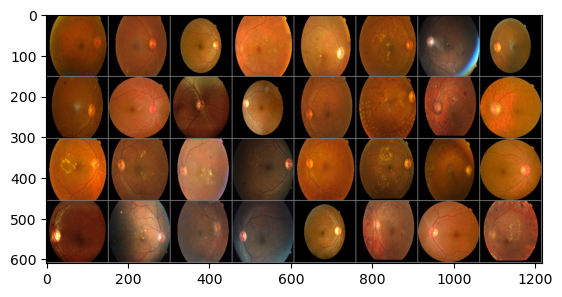

  pdr orta-npdr dr-yok siddetli-npdr orta-npdr orta-npdr   pdr dr-yok orta-npdr dr-yok dr-yok dr-yok orta-npdr   pdr orta-npdr dr-yok orta-npdr hafif-npdr orta-npdr orta-npdr hafif-npdr orta-npdr   pdr dr-yok dr-yok orta-npdr hafif-npdr dr-yok dr-yok orta-npdr dr-yok   pdr
torch.Size([32, 3, 150, 150])


In [16]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
classes = ["dr-yok", "hafif-npdr", "orta-npdr", "siddetli-npdr", "pdr"]

def imshow(img):
    # Verinin normalize edilmesi ve 0-1 arası sayısal bir değere dönüştürülmesi
    img = img / 2 + 0.5
    npimg = img.numpy()  # Verinin numpy array'ine -dizi- dönüştürülmesi
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Veri boyutlarının düzenlenmesi ve ekrana dönüştürülmesi
    plt.show()

# Dataset üzerinden veri çekilmesi
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Alınan görüntülerin ekrana yazdırılması
imshow(torchvision.utils.make_grid(images))

# Verilerin teşhis durumunun yazdırılması
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Veri boyutunun yazdırılması
print(images.size())


# Model Eğitimi Transfer Learning (MobileNetV2)

In [17]:
import time
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

start = time.time()
print("Transfer Learning Eğitimi Başlıyor..")
print("---------------------------------------------")

# Transfer learning için MobileNetV2 modeli hiperparametrelerinin upload edilmesi
model = models.mobilenet_v2(pretrained=True)

# Tüm katmanların dondurulması (ağırlıkları eğitme amacıyla)
for param in model.parameters():
    param.requires_grad = False

# MobilNetV2 modelinin sınıflandırıcı yapay sinir ağı kısmını değiştirilmesi
model.classifier = nn.Sequential(
    nn.Linear(1280, 512),  # Giriş boyutununun 1280'den 512'ye düşürülmesi
    nn.ReLU(inplace=True), # RelU aktivasyon fonksiyonunun kullanılması
    nn.Dropout(0.3),  # Overfitting engelleyici dropout katmanı eklenmesi
    nn.Linear(512, 5)  # 5 sınıflı bir output katmanı eklenmesi
)

# Loss değeri düşürme yönteminin ve kullanılacak optimizasyon algoritmasının belirlenmesi
error = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.0008)

epoch = 50 # Epoch değerinin 50 olarak set edilmesi
count = 0
acc_list = []
iterasyon = []
kayıp = []

for i in range(epoch):
    print("Epoch:", i, "LR:", optimizer.param_groups[0]['lr'])  # Epoch ve ve learning rate değerinin her adımda yazdırılması
    for i, (images, label) in enumerate(train_loader):

        tahmin = model(images)  # Modelden sınıflandırma tahminin alınması
        optimizer.zero_grad()  # Yeni adım için eski adımda kullanılan gradyanların sıfırlanmması
        loss = error(tahmin, label)  # Yanlış sınıflandırılan veri sayısının hesaplanması
        loss.backward()  # Geri yayılım yapılması
        optimizer.step()  # Optimize edlirek ağırlıkların güncellenmesi

        count += 1

        if count % 100 == 0:
            total = 0
            correct = 0
            correct_hata = 0

            for images, labels in test_loader:
                out = model(images.float())  # Modelden sınıflandırma çıktısının alınması
                pred = torch.max(out.data, 1)[1]  # En yüksek tahmin başarımının hesaplanması
                total += len(labels)

                correct += (pred == labels).sum()  # Doğru tahmin edilen veri sayısının hesaplanması
                correct_hata += (pred != labels).sum()  # Hatalı tahmin  edilen veri sayısının hesaplanması

            dogruluk = 100 * correct / float(total)  # Modelin doğruluk skorunun hesaplanması
            hata = 100 * correct_hata / float(total)  # Modelin hata skorunun hesaplanması

            kayıp.append(loss.data)  # Modelin loss değerinin kaydedilmesi
            iterasyon.append(count)  # Modelin iterasyon sayısının kaydedilmesi
            acc_list.append(dogruluk)  # Modelin doğruluk skorunun kaydedilmesi

            if count % 100 == 0:
                print('Iteration: {} Loss: {} Accuracy: {}% Error: {}%'.format(count, loss.data, dogruluk, hata)) # Her 100 iterasyonda loss ve accuracy değerlerinin yazdırılması

print("Transfer Learning Eğitimi Bitti...")
print("---------------------------------------------")

end = time.time()
print("Süre:", end - start)  # Toplam eğitim süresinin yazdırılması

Transfer Learning Eğitimi Başlıyor..
---------------------------------------------
Epoch: 0 LR: 0.0008
Epoch: 1 LR: 0.0008
Iteration: 100 Loss: 0.6220674514770508 Accuracy: 72.09302520751953% Error: 27.9069766998291%
Epoch: 2 LR: 0.0008
Iteration: 200 Loss: 0.6289970874786377 Accuracy: 74.69219970703125% Error: 25.307798385620117%
Epoch: 3 LR: 0.0008
Iteration: 300 Loss: 0.7449422478675842 Accuracy: 74.9657974243164% Error: 25.03420066833496%
Epoch: 4 LR: 0.0008
Iteration: 400 Loss: 0.4130712151527405 Accuracy: 76.06018829345703% Error: 23.939807891845703%
Epoch: 5 LR: 0.0008
Iteration: 500 Loss: 0.4952235221862793 Accuracy: 74.8290023803711% Error: 25.17099952697754%
Epoch: 6 LR: 0.0008
Iteration: 600 Loss: 0.3769935071468353 Accuracy: 75.10260009765625% Error: 24.89739990234375%
Epoch: 7 LR: 0.0008
Iteration: 700 Loss: 0.33675268292427063 Accuracy: 76.47058868408203% Error: 23.52941131591797%
Epoch: 8 LR: 0.0008
Iteration: 800 Loss: 0.5042796730995178 Accuracy: 74.8290023803711% Erro

# Model Sonuçlarını Görselleştirme

In [21]:
from torchsummary import summary
summary(model,input_size=(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 75, 75]             864
       BatchNorm2d-2           [-1, 32, 75, 75]              64
             ReLU6-3           [-1, 32, 75, 75]               0
            Conv2d-4           [-1, 32, 75, 75]             288
       BatchNorm2d-5           [-1, 32, 75, 75]              64
             ReLU6-6           [-1, 32, 75, 75]               0
            Conv2d-7           [-1, 16, 75, 75]             512
       BatchNorm2d-8           [-1, 16, 75, 75]              32
  InvertedResidual-9           [-1, 16, 75, 75]               0
           Conv2d-10           [-1, 96, 75, 75]           1,536
      BatchNorm2d-11           [-1, 96, 75, 75]             192
            ReLU6-12           [-1, 96, 75, 75]               0
           Conv2d-13           [-1, 96, 38, 38]             864
      BatchNorm2d-14           [-1, 96,

# Loss Sonuçlarını Görselleştirme

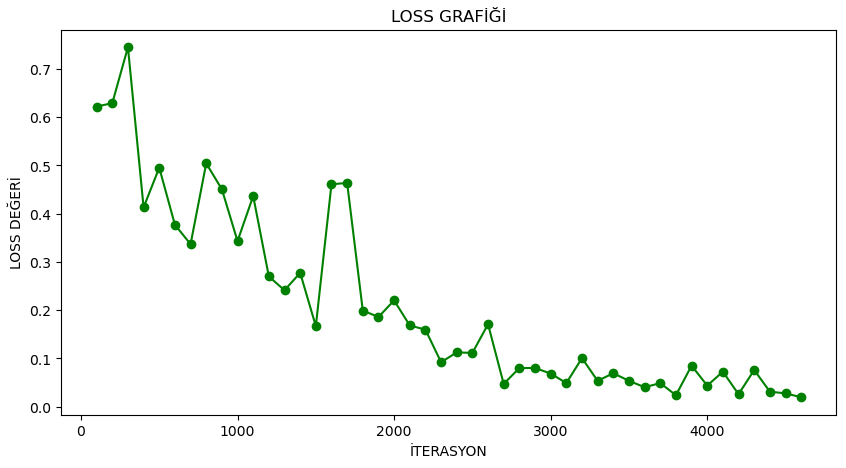

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("LOSS GRAFİĞİ")
plt.plot(iterasyon,kayıp,"-o",color="g")

plt.xlabel("İTERASYON")
plt.ylabel("LOSS DEĞERİ")

plt.show()

# Accuracy Sonuçlarını Görselleştirme

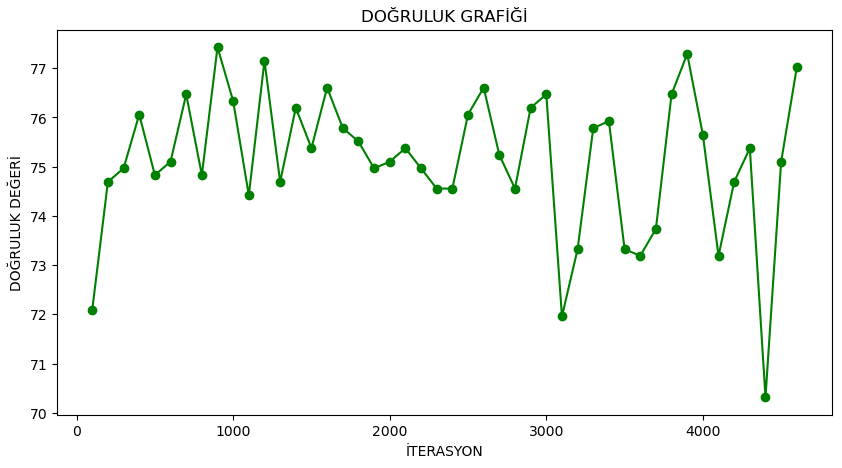

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("DOĞRULUK GRAFİĞİ")
plt.plot(iterasyon,acc_list,"-o",color="g")

plt.xlabel("İTERASYON")
plt.ylabel("DOĞRULUK DEĞERİ")

plt.show()

# Model Save

In [18]:
torch.save(model.state_dict(), r"C:\Users\PC\Desktop\dataset\model.pth")